## Kebutuhan library

In [95]:
import os
import graphviz
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import pydot

from sklearn import tree
from statistics import mean
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import RandomOverSampler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier
os.environ['PATH'] = os.environ['PATH']+';'+os.environ['CONDA_PREFIX']+r"\Library\bin\graphviz"
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO

##### msc

In [59]:
warnings.filterwarnings('ignore')

## Inisialisasi data

In [60]:
working_dir = os.getcwd()

ecoli_file_direktori = os.path.join(working_dir, "ecoli.data")

colnames = ['SEQUENCE_NAME', 'MCG', 'GVH', 'LIP', 'CHG', 'AAC', 'ALM1', 'ALM2', 'CLASS']

ecoli_df = pd.read_csv(ecoli_file_direktori, delim_whitespace=True, names=colnames)

fitur =  ['SEQUENCE_NAME', 'MCG', 'GVH', 'LIP', 'CHG', 'AAC', 'ALM1', 'ALM2']

## Deskripsi data

### Jumlah sample data 

In [61]:
ecoli_df.shape

(336, 9)

### Lihat sebagian samle data

In [62]:
ecoli_df.head()

,SEQUENCE_NAME,MCG,GVH,LIP,CHG,AAC,ALM1,ALM2,CLASS
0,AAT_ECOLI,0.49,0.29,0.48,0.5,0.56,0.24,0.35,cp
1,ACEA_ECOLI,0.07,0.40,0.48,0.5,0.54,0.35,0.44,cp
2,ACEK_ECOLI,0.56,0.40,0.48,0.5,0.49,0.37,0.46,cp
3,ACKA_ECOLI,0.59,0.49,0.48,0.5,0.52,0.45,0.36,cp
4,ADI_ECOLI,0.23,0.32,0.48,0.5,0.55,0.25,0.35,cp


### Lihat kolom, jumlah sample data, dan tipe data 

In [63]:
ecoli_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 0 to 335
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SEQUENCE_NAME  336 non-null    object 
 1   MCG            336 non-null    float64
 2   GVH            336 non-null    float64
 3   LIP            336 non-null    float64
 4   CHG            336 non-null    float64
 5   AAC            336 non-null    float64
 6   ALM1           336 non-null    float64
 7   ALM2           336 non-null    float64
 8   CLASS          336 non-null    object 
dtypes: float64(7), object(2)
memory usage: 23.8+ KB


Terdapat 336 sample data dengan tipe data numerik.

### Lihat kelas

In [64]:
print((ecoli_df['CLASS'].unique()))

['cp' 'im' 'imS' 'imL' 'imU' 'om' 'omL' 'pp']


Pada dataset ini terdapat 8 kelas.

### Deskripsi statistik 

#### Kolom 1 sampai 3

In [65]:
ecoli_df.describe().loc[['count','mean','min','max']]

,MCG,GVH,LIP,CHG,AAC,ALM1,ALM2
count,336.00000,336.00,336.000000,336.000000,336.00000,336.000000,336.000000
mean,0.50006,0.50,0.495476,0.501488,0.50003,0.500179,0.499732
min,0.00000,0.16,0.480000,0.500000,0.00000,0.030000,0.000000
max,0.89000,1.00,1.000000,1.000000,0.88000,1.000000,0.990000


Berdasarkan deskripsi statisiknya, dapat dilihat dari nilai meannya bahwa rentang di antara sample data tidak terlalu jauh. Hal ini menandakan bahwa tidak perlunya dilakukan normalisasi pada data.

### Periksa missing value

In [66]:
ecoli_df.isnull().sum()

SEQUENCE_NAME    0
MCG              0
GVH              0
LIP              0
CHG              0
AAC              0
ALM1             0
ALM2             0
CLASS            0
dtype: int64

Pada dataset ini tidak terdapat missing value, sehingga tidak perlu dilakukan imputasi atau penanganan terhadap missing value.

### Visualisasi sebaran data pada tiap kelas

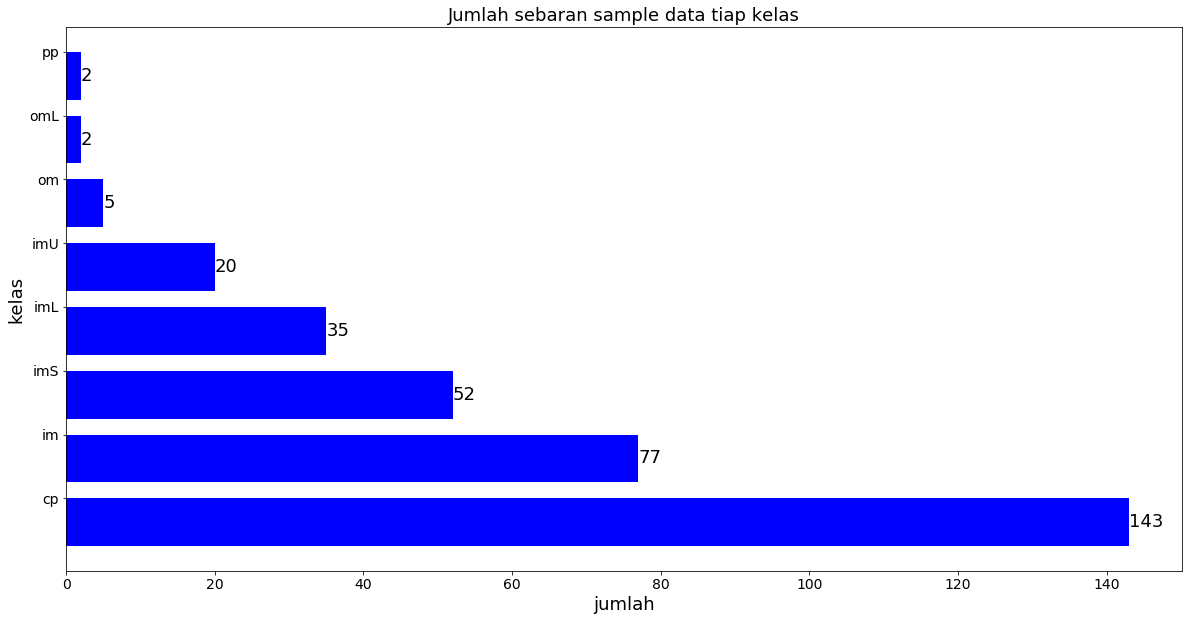

In [67]:
x_plot_before = ecoli_df['CLASS'].unique()
y_plot_before = ecoli_df['CLASS'].value_counts()

fig, ax = plt.subplots(figsize=(20, 10))
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
width = 0.75
ind = np.arange(len(y_plot_before))
ax.barh(ind, y_plot_before, width, color="blue")
ax.set_yticks(ind+width/2)
ax.set_yticklabels(x_plot_before)
plt.title('Jumlah sebaran sample data tiap kelas', fontsize=18)
plt.xlabel('jumlah', fontsize=18)
plt.ylabel('kelas', fontsize=18)

for i, v in enumerate(y_plot_before):
    ax.text(v, i, str(v), va='center', fontsize=18)
plt.show()

Seperti yang dapat dilihat pada plot di atas bahwa sebaran data sangat tidak seimbang atau dataset ini adalah dataset yang imbalanced. Dapat dilihat bahwa jumlah sample data pada kelas __pp__ hanya sejumlah 2, sedangkan jumlah sample data pada kelas __cp__ berjumlah 143.

## Preprocessing data

### Penghapusan kolom SEQUENCE_NAME

Kolom __SEQUENCE_NAME__ akan dihapus karena kolom tersebut merupakan ID dari tiap sample data.

In [68]:
ecoli_df_2 = ecoli_df.drop('SEQUENCE_NAME', axis=1)
ecoli_df_2.head()

,MCG,GVH,LIP,CHG,AAC,ALM1,ALM2,CLASS
0,0.49,0.29,0.48,0.5,0.56,0.24,0.35,cp
1,0.07,0.40,0.48,0.5,0.54,0.35,0.44,cp
2,0.56,0.40,0.48,0.5,0.49,0.37,0.46,cp
3,0.59,0.49,0.48,0.5,0.52,0.45,0.36,cp
4,0.23,0.32,0.48,0.5,0.55,0.25,0.35,cp


### Resampling data

Seperti yang sudah dijelaskan sebelumnya bahwa dataset ini adalah dataset yang tidak seimbang. Maka dari itu, kami akan melakukan resampling data yang bertujuan untuk membuat sample data baru untuk menyeimbangkan dataset.

Untuk referensi resampling data diambil dari sini: [Resampling strategies for imbalanced datasets](https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets), [How to do cross-validation when upsampling data](https://kiwidamien.github.io/how-to-do-cross-validation-when-upsampling-data.html), [An opinionated guide to imbalanced classes](https://soph.info/2019/05/07/imbalance/).

Metode yang kami ambil untuk melakukan resampling data adalah metode ROS (Random Over Sampling). Metode ini akan melakukan penambahan jumlah sample data berdasarkan contoh dari sample data asli. Sayangnya metode ini tidak menambahkan variasi sample data. Berikut adalah ilustrasi dari metode ROS:

<img src="ros_sampling.png">

Yang akan dilakukan di bawah ini hanyalah sebagai contoh untuk mempraktekkan resampling data. Proses resampling data yang sesungguhnya akan dilakukan di dalam proses cross validation bersamaan dengan proses modeling.

#### Pisahkan dataset menjadi dataframe X dan y

X adalah dataframe yang menampung atribut atau fitur, y adalah dataframe yang menampung kelas.

In [69]:
fitur = ['MCG','GVH','LIP','CHG','AAC','ALM1','ALM2']
kelas = ['CLASS']

X = np.array(ecoli_df_2[fitur])
y = np.array(ecoli_df_2[kelas])

#### Lakukan pembagian dataset menjadi training set dan testing set

Pembagian akan dilakukan dengan presentase 70% training set dan 30% testing set. Pembagian dataset dilakukan dengan menggunakan fungsi train_test_split().

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

#### Resampling dengan metode ROS

Resampling data hanya dilakukan pada training setnya saja.

In [71]:
ros_resampler = RandomOverSampler(random_state=42)
X_res, y_res = ros_resampler.fit_sample(X_train, y_train)

print('Jumlah sample data pada training set sebelum resampling data {}' . format(X_train.shape))
print('Jumlah sample data pada training set setelah resampling data {}' . format(X_res.shape))

Jumlah sample data pada training set sebelum resampling data (235, 7)
Jumlah sample data pada training set setelah resampling data (776, 7)


#### Visualisasi sebaran data setelah resampling data

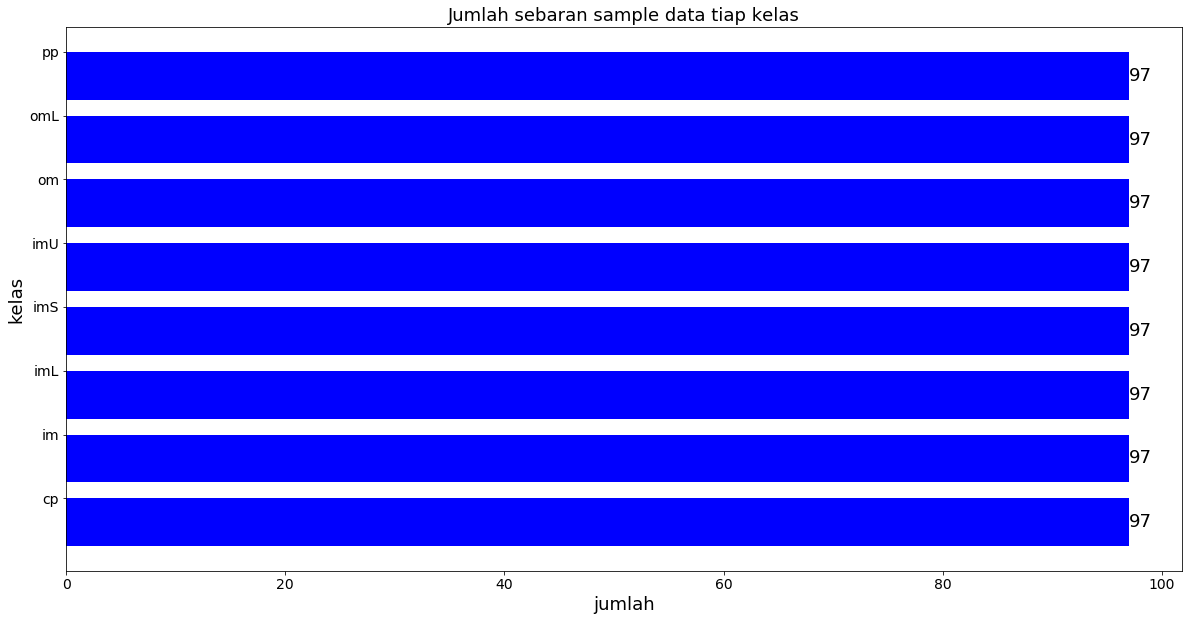

In [72]:
x_plot_after, y_plot_after = np.unique(y_res, return_counts=True)

fig, ax = plt.subplots(figsize=(20, 10))
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
width = 0.75
ind = np.arange(len(y_plot_after))
ax.barh(ind, y_plot_after, width, color="blue")
ax.set_yticks(ind+width/2)
ax.set_yticklabels(x_plot_after)
plt.title('Jumlah sebaran sample data tiap kelas', fontsize=18)
plt.xlabel('jumlah', fontsize=18)
plt.ylabel('kelas', fontsize=18)

for i, v in enumerate(y_plot_after):
    ax.text(v, i, str(v), va='center', fontsize=18)
plt.show()

## Modeling

### Inisiasi kfold

Pada praktek ini akan digunakan StratifiedKFold dengan jumlah k=10 atau dataset akan dibagi menjadi 10 partisi. Sedangkan StratifiedKFold akan membagi data dengan proporsi yang seseimbang mungkin, yaitu presentase pembagian data di tiap partisinya akan sama.

In [73]:
kf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

### Inisiasi model GaussianNB

#### Model

In [74]:
gaussiannb_clf = GaussianNB

#### Parameter model GaussianNB

Model gaussian tidak menerima parameter apapun sehingga dapat dikosongkan.

In [75]:
gaussiannb_parameter = {}

### Inisiasi model RandomForestClassifier

#### Model

In [76]:
randomforest_clf = RandomForestClassifier


#### Parameter model RandomForestClassifier

Ini bisa diubah-ubah. Mungkin ada parameter lain yang menghasilkan akurasi lebih baik. Referensi liat di sini: [How to do cross-validation when upsampling data](https://kiwidamien.github.io/how-to-do-cross-validation-when-upsampling-data.html). Setiap kali ubah parameter, compile lagi, dan jalanin lagi fungsi get_score(). Kalo udah dapet akurasi setelah ganti parameter, catet akurasinya di excel buat perbandingan.

In [77]:
randomforest_parameter = {'n_estimators': 200, 'max_depth': 7, 'random_state': 13}

### Inisiasi model DecisionTreeClassifier

#### Model

In [78]:
DecisionTree_clf = DecisionTreeClassifier
clf = DecisionTree_clf.fit

#### Parameter model DecisionTreeClassifier

Ini bisa dubah-ubah juga. Mungkin ada parameter lain yang menghasilkan akurasi lebih baik. Referensi liat di sini: [How to tune a Decision Tree?](https://towardsdatascience.com/how-to-tune-a-decision-tree-f03721801680). Setiap kali ubah parameter, compile lagi, dan jalanin lagi fungsi get_score(). Kalo udah dapet akurasi setelah ganti parameter, catet akurasinya di excel buat perbandingan.

In [79]:
decisiontree_parameter = {}

### Fungsi untuk resampling dan modeling di dalam cross validation

In [80]:
def get_score(model, params, cv=None):
    if cv is None:
        cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
    
    ros = RandomOverSampler(random_state=42)
    
    scores = []
    
    for train_fold_index, test_fold_index in cv.split(X_train, y_train):
        # generate training set
        X_train_fold, y_train_fold = X_train[train_fold_index], y_train[train_fold_index]
        # generate testing set
        X_test_fold, y_test_fold = X_train[test_fold_index], y_train[test_fold_index]
        # resampling data hanya pada training set saja
        X_train_fold_resample, y_train_fold_resample = ros.fit_sample(X_train_fold, y_train_fold)
        # fit model pada training set yang telah diresample
        model_obj = model(**params).fit(X_train_fold_resample, y_train_fold_resample)
        # nilai model pada testing set
        score = accuracy_score(y_test_fold, model_obj.predict(X_test_fold))
        # masukkan score ke dalam array scores
        scores.append(score)
    
    return np.array(scores)

### Score untuk model GaussianNB

#### Array score

In [81]:
print(get_score(GaussianNB, gaussiannb_parameter, cv=kf))

[0.79166667 0.79166667 0.83333333 0.70833333 0.79166667 0.73913043
 0.7826087  0.7826087  0.73913043 0.86956522]


#### Rata-rata akurasi

In [82]:
print(mean(get_score(gaussiannb_clf, gaussiannb_parameter, cv=kf)))

0.7829710144927536


### Score untuk model RandomForestClassifier

#### Array score

In [83]:
print(get_score(randomforest_clf, randomforest_parameter, cv=kf))

[0.79166667 0.875      0.79166667 0.83333333 0.875      0.91304348
 0.7826087  0.86956522 0.82608696 0.91304348]


#### Rata-rata akurasi

In [84]:
print(mean(get_score(randomforest_clf, randomforest_parameter, cv=kf)))

0.8471014492753624


### Score untuk model DecisionTreeClassifier

#### Array score

In [85]:
print(get_score(DecisionTree_clf, decisiontree_parameter))

[0.83333333 0.70833333 0.75       0.70833333 0.75       0.7826087
 0.82608696 0.86956522 0.82608696 0.82608696]


#### Rata-rata akurasi

In [86]:
print(mean(get_score(DecisionTree_clf, decisiontree_parameter)))

0.7795289855072464


In [97]:
##Visualisasi Random Forest

rf_small = RandomForestClassifier(n_estimators=10, max_depth = 3)
rf_small.fit(X_train,y_train)

#extract small tree
tree_small = rf_small.estimators_[5]

# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree_rf.dot', feature_names = fitur, rounded = True, precision = 1)

(graph, ) = pydot.graph_from_dot_file('C:/Users/roiha/OneDrive/Documents/roihan/KULIAH/SEMESTER 6/MACHINE LEARNING/TEORI/ta_machine-learning(2)/small_tree_rf.dot')

graph.write_png('C:/Users/roiha/OneDrive/Documents/roihan/KULIAH/SEMESTER 6/MACHINE LEARNING/TEORI/ta_machine-learning(2)/small_tree_rf.png')
